In [166]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point
import pandas as pd
import requests
import networkx as nx
import osmnx as ox

In [2]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [3]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [4]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

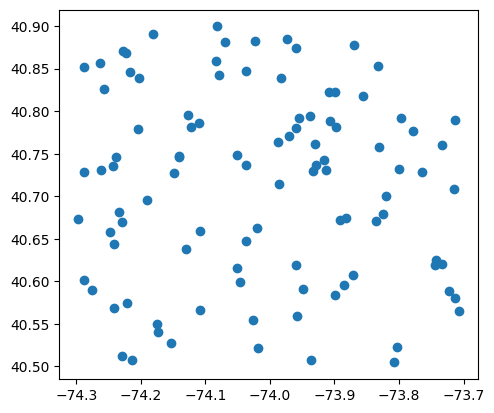

In [5]:
gdf.plot()

In [84]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_13151/2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [85]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]"
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]"
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]"
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]"


In [133]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [134]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [135]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [136]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

<Axes: >

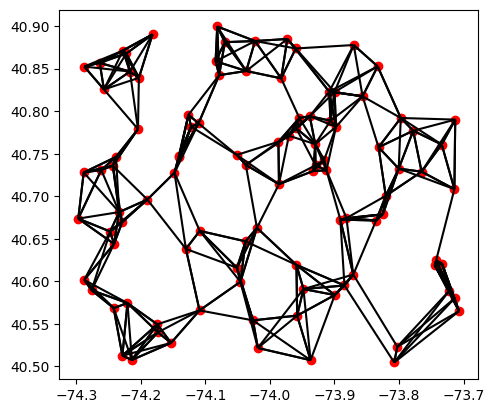

In [137]:
ax = lines_gdf.plot(color="black")
gdf.plot(ax=ax, color="red")

<Axes: >

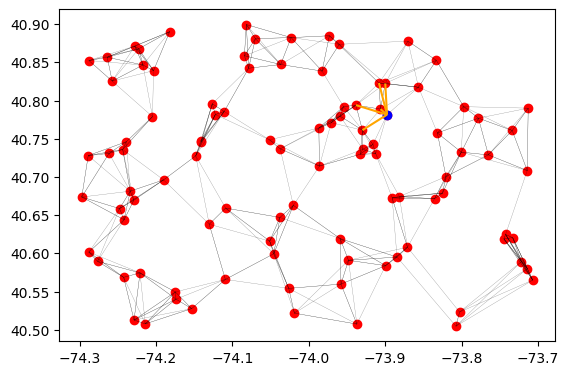

In [140]:
# plot the lines for a single point
s = gdf.sample(1)
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [154]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [155]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [159]:
mh_restaurants.fillna("na", inplace=True)

In [161]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'record_date',
       'inspection_type', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [299]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [300]:
mh_restaurants.grade.value_counts()

grade
A     74
na    73
B      7
N      7
C      4
Z      1
Name: count, dtype: int64

In [301]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        21
na                                11
Pizza                             10
Chinese                           10
Italian                            8
Mexican                            8
Japanese                           5
Hamburgers                         4
Asian/Asian Fusion                 4
French                             4
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
Thai                               3
Indian                             3
Ethiopian                          3
Bakery Products/Desserts           3
Fusion                             2
Mediterranean                      2
Latin American                     2
Sandwiches/Salads/Mixed Buffet     2
Other                              2
Donuts                             2
Hawaiian                           2
Tex-Mex                            2
Middle Eastern                     2
Greek             

## build graph to allow us to search


In [302]:
mh_bbox = mh_restaurants.total_bounds

In [303]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [304]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_13151/307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [305]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

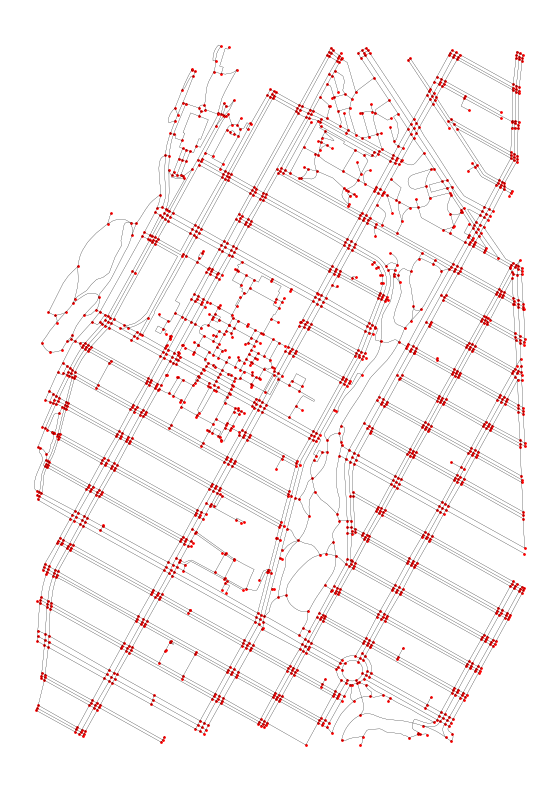

In [306]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="red", markersize=1).set_axis_off()

In [307]:
avery_hall = Point(-73.9614755, 40.8081037)

### get directions between avery hall and a random restaurant using osmnx


In [308]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, avery_hall.x, avery_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

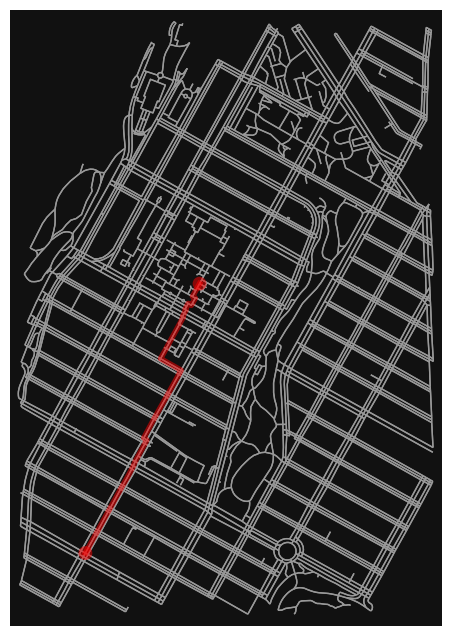

In [309]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [310]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.6302254340288566

In [311]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

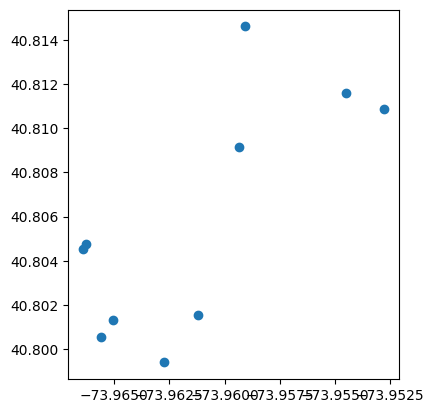

In [312]:
mh_pizza.plot()

In [313]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [314]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [315]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [316]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Avery Hall to \n Morningside Heights Pizza Restaurants')

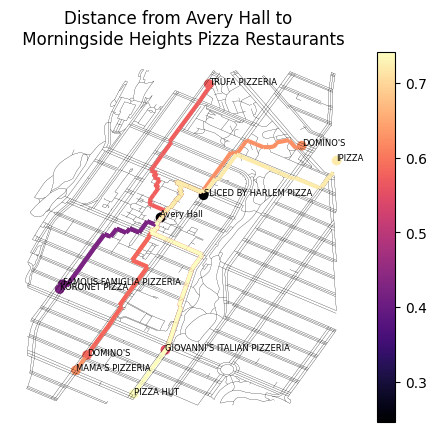

In [317]:
ax = gpd.GeoSeries(avery_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(avery_hall.x, avery_hall.y, "Avery Hall", fontsize=6)

# title
plt.title("Distance from Avery Hall to \n Morningside Heights Pizza Restaurants")

In [318]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
14,SLICED BY HARLEM PIZZA,0.246334
41,KORONET PIZZA,0.423456
312,FAMOUS FAMIGLIA PIZZERIA,0.423456
172,GIOVANNI'S ITALIAN PIZZERIA,0.556726
191,TRUFA PIZZERIA,0.573658
194,DOMINO'S,0.579761
19,DOMINO'S,0.626303
10,MAMA'S PIZZERIA,0.630225
346,IPIZZA,0.720836
706,PIZZA HUT,0.740747


<Axes: >

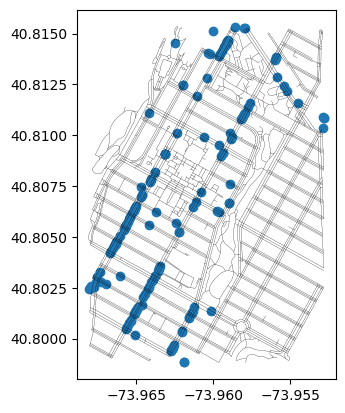

In [319]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [ ]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons